<a href="https://colab.research.google.com/github/arallina/Laboratorio-DF/blob/main/Metodo_de_imagenes.F3ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Método de imagenes**

En base a lo que vimos en la teórica y la práctica, el método de imagenes consiste en agregar una densidad de carga $\rho'$ a la original $\rho$.
La posicion e intensidad de estas nuevas cargas dependerá de la geometría del conductor, pero en general podemos asumir que habrá una función $\bar{f}:\mathbb{R}^3\to\mathbb{R}^3$ que para cada punto $\bar{r}$ donde haya carga me dirá el punto $\bar{f}(\bar{r})$ donde estará su imagen. La carga de esta imagen será $g(\bar{r})q$ con $g:\mathbb{R}^3\to\mathbb{R}$

Con esta función $\bar{f}$, podemos entonces escribir la densidad adicional cómo

$$\rho'(\bar{r}) = g(\bar{r})\rho(\bar{f}(\bar{r}))$$

Por ejemplo, para un conductor plano en $y=0$, $\bar{f}$ esta función es la reflexión de la componente $y$ y $g$ es la función constantemente $-1$

\begin{equation}\tag{1}
\bar{f}(\bar{r}) = x\hat{x} - y\hat{y} + z\hat{z} = \bar{r} - 2(\bar{r}\cdot\hat{y})\hat{y} \quad, \qquad g(\bar{r}) = -1
\end{equation}


Por superposición, sabemos entonces que el campo total será
$$\bar{E}(\bar{r}) = \bar{E}_{\rho'}(\bar{r}) + \bar{E}_\rho(\bar{r})$$
donde podemos escribir $\bar{E}_{\rho'}$ en términos de $\bar{f}$, $g$ y $\rho$ cómo

\begin{align*}
\bar{E}_{\rho'}(\bar{r}) = k\int \rho'(\bar{r}')\frac{\bar{r}-\bar{r}'}{|\bar{r}-\bar{r}'|^3} dV' = k\int g(\bar{r}')\rho(\bar{f}(\bar{r}'))\frac{\bar{r}-\bar{r}'}{|\bar{r}-\bar{r}'|^3} dV'
\end{align*}

Desafortunadamente, no es trivial expresar $\bar{E}_{\rho'}$ en términos de $\bar{f}$, $g$ y $\bar{E}_{\rho}$ para $\bar{f},g$ arbitrarios.
Esto se complejiza por la necesidad de transformar la geometría sobre la que $\rho$ está definida ante $\bar{f}$.

Tiempo: 12.88 segundos


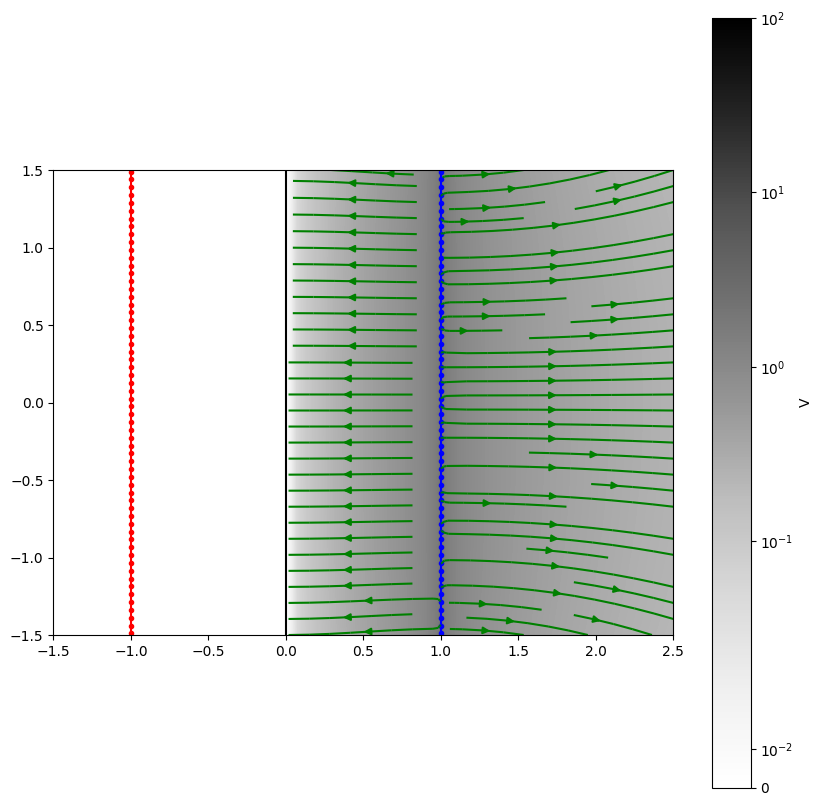

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, SymLogNorm
from numba import njit
import time

#@njit()
def plane_reflection(r, axis=0):
  r_ref = r.copy()
  r_ref[axis] = -r_ref[axis]
  return r_ref

#@njit()
def E_x(x, y): # Tomo k*q=1 para simplificar
  r = np.sqrt(x**2+y**2)
  return x/r**3

#@njit()
def E_y(x, y): # Tomo k*q=1 para simplificar
  r = np.sqrt(x**2+y**2)
  return y/r**3

#@njit()
def pot(x, y): # Tomo k*q=1 para simplificar
  r = np.sqrt(x**2+y**2)
  return 1/r


#@njit()
def E_plane_ref(Xs, Ys, Xs_source, Ys_source, qs):
  """
  Xs, Ys              : Puntos campo (en mesh!)
  Xs_source, Ys_source: Puntos fuente (1D array)
  qs                  : Carga de cada carga en (Xs_source[i], Ys_source[i])
  """
  N = len(Xs_source)
  Ex = np.zeros_like(Xs)
  Ey = np.zeros_like(Xs)
  V = np.zeros_like(Xs)
  Xs_ref = np.zeros_like(Xs_source)
  Ys_ref = np.zeros_like(Ys_source)
  qis = np.zeros_like(qs)
  for i in range(N):
    Xs_ref[i], Ys_ref[i] = plane_reflection(np.array([Xs_source[i], Ys_source[i]]))
    Ex += qs[i]*(E_x(Xs - Xs_source[i], Ys - Ys_source[i]) - E_x(Xs - Xs_ref[i], Ys - Ys_ref[i]))
    Ey += qs[i]*(E_y(Xs - Xs_source[i], Ys - Ys_source[i]) - E_y(Xs - Xs_ref[i], Ys - Ys_ref[i]))
    V += qs[i]*(pot(Xs - Xs_source[i], Ys - Ys_source[i]) - pot(Xs - Xs_ref[i], Ys - Ys_ref[i]))
  V[V >= 1e3] = 0
  V[V <= -1e3] = 0
  Ex = Ex*(Xs_mesh >= 0) # Dentro del conductor
  Ey = Ey*(Xs_mesh >= 0) # tanto campo como
  V = V*(Xs_mesh >= 0)   # potencial son nulos
  return Xs_ref, Ys_ref, V, Ex, Ey


init = time.time()
# Defino una distribución discreta "parecida" a alguna continua que quiera
# Hilo con largo L=2 y carga total Q=1 como N cargas equiespaciadas q=1/N
N = 100
d = 1.0   # Distancia del centro del hilo al centro de la esfera
L = 5.0
# Puntos fuente
Xs_hilo = d*np.ones(N)
Ys_hilo = (L/2)*np.linspace(-1, 1, N)
qs = np.ones(N)/N
# Puntos Campo
Xs = np.linspace(-1.5, 2.5, 801)
Ys = np.linspace(-1.5, 1.5, 601)
Xs_mesh, Ys_mesh = np.meshgrid(Xs, Ys)
Xs_ref, Ys_ref, V, Ex, Ey = E_plane_ref(Xs_mesh, Ys_mesh, Xs_hilo, Ys_hilo, qs)

fig1 = plt.figure(figsize=(10, 10))
fig1.add_subplot(111,aspect='equal')
thetas = np.linspace(0, 2*np.pi, 2001)
plt.plot([0, 0], [Ys[0], Ys[-1]], "k-")
plt.plot(Xs_hilo, Ys_hilo, "b.-")
plt.plot(Xs_ref, Ys_ref, "r.-")
plt.streamplot(Xs, Ys, Ex, Ey, color="g", density=1)
plt.imshow(V, extent=[Xs[0], Xs[-1], Ys[0], Ys[-1]], aspect="equal", norm=SymLogNorm(0.05), cmap=plt.cm.Greys)
plt.colorbar(label="V")
plt.xlim(Xs[0], Xs[-1])
plt.ylim(Ys[0], Ys[-1])
print("Tiempo: %.2f segundos" %(time.time() - init))
plt.show()

## **Esfera conductora a tierra**

En la teórica, vieron el caso de una esfera conductora de radio $R$ en el origen frente a una carga $q$ en $\bar{r}'=d\hat{x}$.
Construyeron una carga imagen $q_i=-qa/d$ en $\bar{r}_i'=\hat{x}R^2/d$, pero esta idea puede generalizarse para una carga $q$ en un punto arbitrario $\bar{r}'$ cómo
$$ \bar{r}_i' = \frac{R^2}{r'^2} \bar{r}' \quad , \qquad q_i = - q\frac{R}{r}$$
por lo que nuestras $\bar{f}$ y $g$ son
$$ \bar{f}(\bar{r}) = \frac{R^2}{r^2}\bar{r} \quad , \qquad g(\bar{r}) = -\frac{R}{r}$$

Acá vemos que la imagen de un $\bar{r}$ fuera del conductor estará en su interior y viceversa.
$$\text{Si } r>R: \qquad |\bar{f}(\bar{r})| = \frac{R^2}{r^2}|\bar{r}| = R \frac{R}{r} < R$$
$$\text{Si } r<R: \qquad |\bar{f}(\bar{r})| = \frac{R^2}{r^2}|\bar{r}| = R \frac{R}{r} > R$$

Tiempo: 13.00 segundos


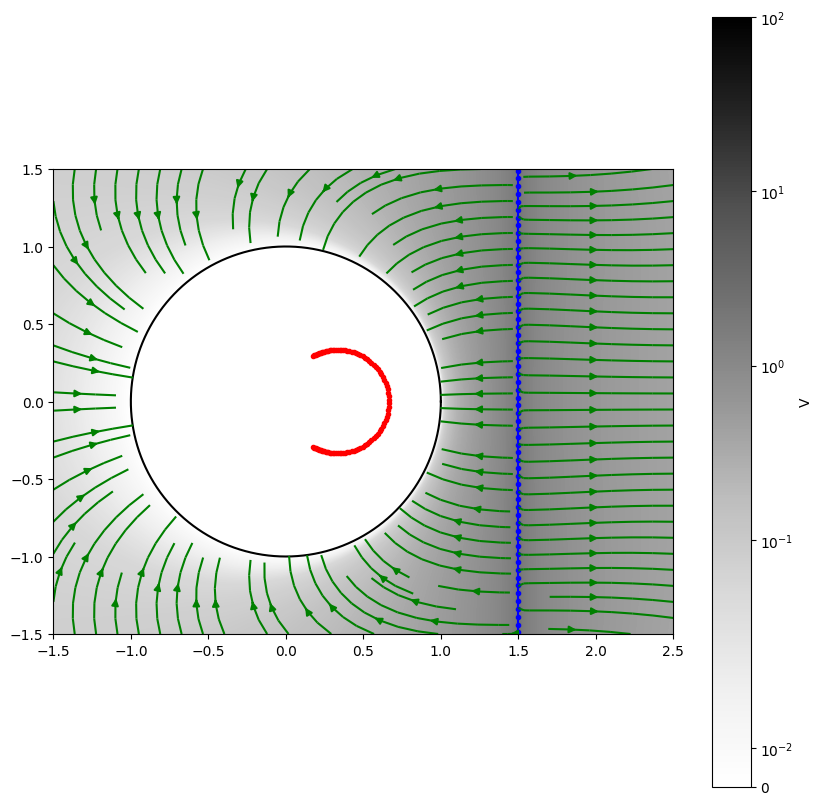

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, SymLogNorm
from numba import njit
import time

#@njit()
def sphere_reflection(r, R=1):
  r_ref = r.copy()
  r_norm2 = r[0]**2 + r[1]**2
  r_ref = R*R*r/r_norm2
  return r_ref[0], r_ref[1], -R/np.sqrt(r_norm2)

#@njit()
def E_x(x, y): # Tomo k*q=1 para simplificar
  r = np.sqrt(x**2+y**2)
  return x/r**3

#@njit()
def E_y(x, y): # Tomo k*q=1 para simplificar
  r = np.sqrt(x**2+y**2)
  return y/r**3

#@njit()
def pot(x, y): # Tomo k*q=1 para simplificar
  r = np.sqrt(x**2+y**2)
  return 1/r

#@njit()
def E_sphere_ref(Xs, Ys, Xs_source, Ys_source, qs):
  """
  Xs, Ys              : Puntos campo (en mesh!)
  Xs_source, Ys_source: Puntos fuente (1D array)
  qs                  : Carga de cada carga en (Xs_source[i], Ys_source[i])
  """
  N = len(Xs_source)
  Ex = np.zeros_like(Xs)
  Ey = np.zeros_like(Xs)
  V = np.zeros_like(Xs)
  Xs_ref = np.zeros_like(Xs_source)
  Ys_ref = np.zeros_like(Ys_source)
  qis = np.zeros_like(qs)
  for i in range(N):
    Xs_ref[i], Ys_ref[i], g = sphere_reflection(np.array([Xs_source[i], Ys_source[i]]))
    Ex += qs[i]*(E_x(Xs - Xs_source[i], Ys - Ys_source[i]) + g*E_x(Xs - Xs_ref[i], Ys - Ys_ref[i]))
    Ey += qs[i]*(E_y(Xs - Xs_source[i], Ys - Ys_source[i]) + g*E_y(Xs - Xs_ref[i], Ys - Ys_ref[i]))
    V += qs[i]*(pot(Xs - Xs_source[i], Ys - Ys_source[i]) + g*pot(Xs - Xs_ref[i], Ys - Ys_ref[i]))
    qis[i] = g*qs[i]
  V[V >= 1e3] = 0
  Ex = Ex*(Xs_mesh**2+Ys_mesh**2 >= 1) # Dentro del conductor
  Ey = Ey*(Xs_mesh**2+Ys_mesh**2 >= 1) # tanto campo como
  V = V*(Xs_mesh**2+Ys_mesh**2 >= 1)   # potencial son nulos
  return Xs_ref, Ys_ref, qis, V, Ex, Ey

init = time.time()
# Defino una distribución discreta "parecida" a alguna continua que quiera
# Hilo con largo L=1 y carga total Q=1 como N cargas equiespaciadas q=1/N
N = 100
d = 1.5   # Distancia del centro del hilo al centro de la esfera
L = 5.0
# Puntos fuente
Xs_hilo = d*np.ones(N)
Ys_hilo = (L/2)*np.linspace(-1, 1, N)
qs = np.ones(N)/N
# Puntos Campo
Xs = np.linspace(-1.5, 2.5, 801)
Ys = np.linspace(-1.5, 1.5, 601)
Xs_mesh, Ys_mesh = np.meshgrid(Xs, Ys)
Xs_ref, Ys_ref, qis, V, Ex, Ey = E_sphere_ref(Xs_mesh, Ys_mesh, Xs_hilo, Ys_hilo, qs)

fig1 = plt.figure(figsize=(10, 10))
fig1.add_subplot(111,aspect='equal')
thetas = np.linspace(0, 2*np.pi, 2001)
plt.plot(np.cos(thetas), np.sin(thetas), "k-")
plt.plot(Xs_hilo, Ys_hilo, "b.-")
plt.plot(Xs_ref, Ys_ref, "r.-")
plt.streamplot(Xs, Ys, Ex, Ey, color="g", density=1)
plt.imshow(V, extent=[Xs[0], Xs[-1], Ys[0], Ys[-1]], aspect="equal", norm=SymLogNorm(0.05), cmap=plt.cm.Greys)
plt.colorbar(label="V")
plt.xlim(Xs[0], Xs[-1])
plt.ylim(Ys[0], Ys[-1])
print("Tiempo: %.2f segundos" %(time.time() - init))
plt.show()

<ipython-input-4-eb0cfe84a6a3>:17: RuntimeWarning: invalid value encountered in true_divide
  return x/r**3
<ipython-input-4-eb0cfe84a6a3>:22: RuntimeWarning: invalid value encountered in true_divide
  return y/r**3
<ipython-input-4-eb0cfe84a6a3>:27: RuntimeWarning: divide by zero encountered in true_divide
  return 1/r


Tiempo: 7.67 segundos


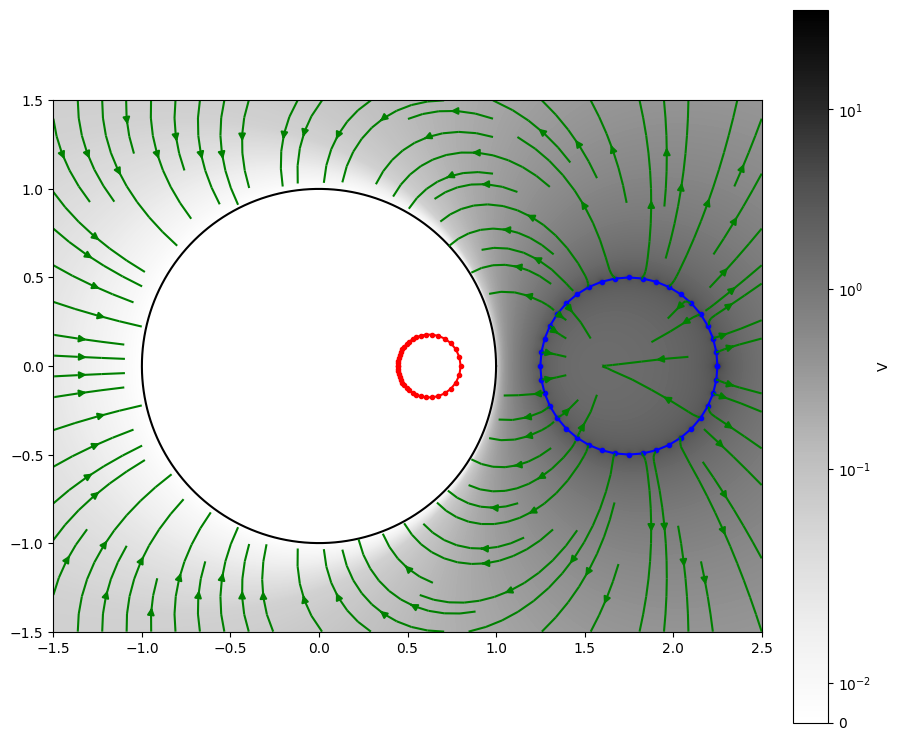

In [ ]:
init = time.time()
# Anillo de radio a=0.5 y carga total Q=1 como N cargas equiespaciadas q=1/N
N = 41
d = 1.75 # Distancia del centro del anillo al centro de la esfera
a = 0.5
# Puntos fuente
thetas = np.linspace(0, 2*np.pi, N)
#Xs_hilo = d + a*np.concatenate([np.cos(thetas), .75*np.cos(thetas), .5*np.cos(thetas), .25*np.cos(thetas)])
#Ys_hilo = a*np.concatenate([np.sin(thetas), .75*np.sin(thetas), .5*np.sin(thetas), .25*np.sin(thetas)])
Xs_hilo = d + a*np.cos(thetas)
Ys_hilo = a*np.sin(thetas)
qs = np.ones(N)/N
# Puntos Campo
Xs = np.linspace(-1.5, 2.5, 801)
Ys = np.linspace(-1.5, 1.5, 601)
Xs_mesh, Ys_mesh = np.meshgrid(Xs, Ys)
Xs_ref, Ys_ref, qis, V, Ex, Ey = E_sphere_ref(Xs_mesh, Ys_mesh, Xs_hilo, Ys_hilo, qs)

fig1 = plt.figure(figsize=(10, 10))
fig1.add_subplot(111,aspect='equal')
thetas = np.linspace(0, 2*np.pi, 2001)
plt.plot(np.cos(thetas), np.sin(thetas), "k-")
plt.plot(Xs_hilo, Ys_hilo, "b.-")
plt.plot(Xs_ref, Ys_ref, "r.-")
plt.streamplot(Xs, Ys, Ex, Ey, color="g", density=1)
x_circ = np.linspace(-1, 1, 2001)
plt.imshow(V, extent=[Xs[0], Xs[-1], Ys[0], Ys[-1]], aspect="equal", norm=SymLogNorm(0.05), cmap=plt.cm.Greys)
plt.colorbar(label="V", fraction=0.046, pad=0.04)
plt.xlim(Xs[0], Xs[-1])
plt.ylim(Ys[0], Ys[-1])
print("Tiempo: %.2f segundos" %(time.time() - init))

<ipython-input-4-eb0cfe84a6a3>:17: RuntimeWarning: invalid value encountered in true_divide
  return x/r**3
<ipython-input-4-eb0cfe84a6a3>:22: RuntimeWarning: invalid value encountered in true_divide
  return y/r**3
<ipython-input-4-eb0cfe84a6a3>:27: RuntimeWarning: divide by zero encountered in true_divide
  return 1/r


Tiempo: 20.65 segundos


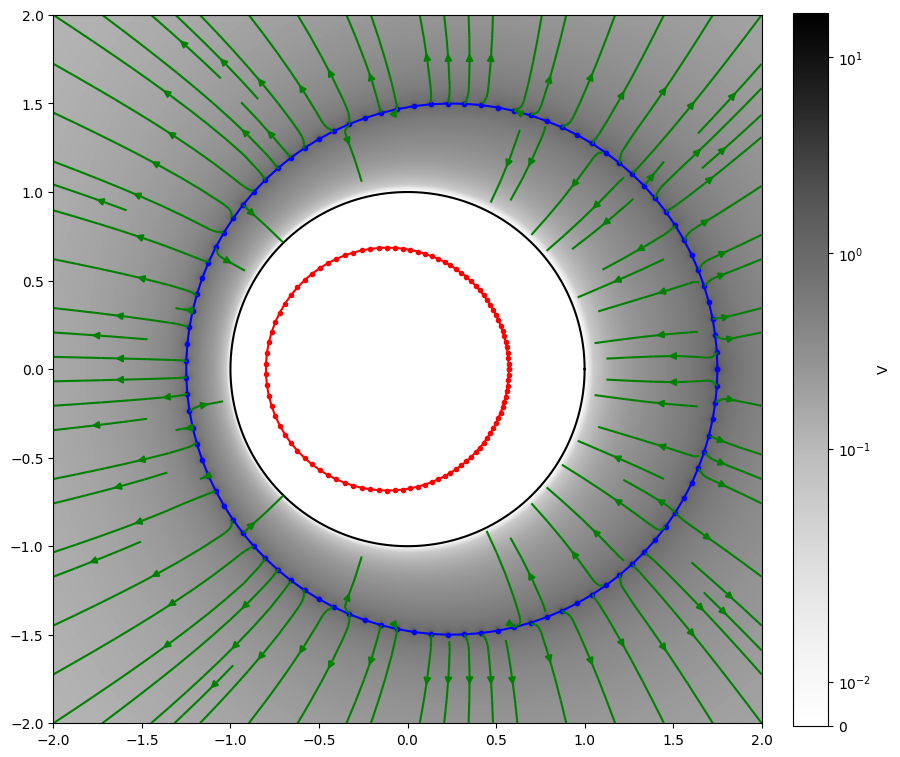

In [ ]:
init = time.time()
# Anillo de radio a=0.5 y carga total Q=1 como N cargas equiespaciadas q=1/N
N = 100
d = 0.25 # Distancia del centro del anillo al centro de la esfera
a = 1.5
# Puntos fuente
thetas = np.linspace(0, 2*np.pi, N)
#Xs_hilo = d + a*np.concatenate([np.cos(thetas), .75*np.cos(thetas), .5*np.cos(thetas), .25*np.cos(thetas)])
#Ys_hilo = a*np.concatenate([np.sin(thetas), .75*np.sin(thetas), .5*np.sin(thetas), .25*np.sin(thetas)])
Xs_hilo = d + a*np.cos(thetas)
Ys_hilo = a*np.sin(thetas)
qs = np.ones(N)/N
# Puntos Campo
Xs = np.linspace(-2, 2, 801)
Ys = np.linspace(-2, 2, 801)
Xs_mesh, Ys_mesh = np.meshgrid(Xs, Ys)
Xs_ref, Ys_ref, qis, V, Ex, Ey = E_sphere_ref(Xs_mesh, Ys_mesh, Xs_hilo, Ys_hilo, qs)

fig1 = plt.figure(figsize=(10, 10))
fig1.add_subplot(111,aspect='equal')
thetas = np.linspace(0, 2*np.pi, 2001)
plt.plot(np.cos(thetas), np.sin(thetas), "k-")
plt.plot(Xs_hilo, Ys_hilo, "b.-")
plt.plot(Xs_ref, Ys_ref, "r.-")
plt.streamplot(Xs, Ys, Ex, Ey, color="g", density=1)
x_circ = np.linspace(-1, 1, 2001)
plt.imshow(V, extent=[Xs[0], Xs[-1], Ys[0], Ys[-1]], aspect="equal", norm=SymLogNorm(0.05), cmap=plt.cm.Greys)
plt.colorbar(label="V", fraction=0.046, pad=0.04)
plt.xlim(Xs[0], Xs[-1])
plt.ylim(Ys[0], Ys[-1])
print("Tiempo: %.2f segundos" %(time.time() - init))